In [1]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
import random

In [2]:
processor = AutoProcessor.from_pretrained("./SmolVLM-256M-Detection2/")

In [3]:
model = AutoModelForVision2Seq.from_pretrained(
    "./SmolVLM-256M-Detection2/",
    torch_dtype=torch.bfloat16,
).to('cuda')
model.eval()

%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [4]:
import re

In [5]:
def tokens_to_bbox(tokens,img_width,img_height,num_tokens=256):
    """
    token[y_min, x_min, y_max, x_max] -> (x,y,w,h)
    """
    y_min, x_min, y_max, x_max = [int(re.search(r"\d+", t).group()) for t in tokens]

    assert not any(v>num_tokens-1 or v<0 for v in [y_min, x_min, y_max, x_max]), f'incorrect tokens: {tokens}'

    x_min = (x_min / (num_tokens-1)) * img_width
    y_min = (y_min / (num_tokens-1)) * img_height
    x_max = (x_max / (num_tokens-1)) * img_width
    y_max = (y_max / (num_tokens-1)) * img_height

    bbox = [round(x_min,2), round(y_min,2), round(x_max-x_min, 2), round(y_max-y_min,2)]
    return bbox

In [6]:
def predict_bbox(input_text,im):
    example = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": input_text}
            ]
        }
    ]
    text = processor.apply_chat_template(example,tokenize=False,add_generation_prompt=True)
    inputs = processor(
        text=text,
        images=im,
        return_tensors='pt',
        size={'longest_edge': 512},
        padding=True
    ).to('cuda')

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=200, num_beams=4, do_sample=True)

    if len(output_ids) > 0:
        selected = random.choice(output_ids)
    else:
        selected = output_ids[0]
    output_text = processor.tokenizer.decode(selected, skip_special_tokens=True)
    print(output_text)

    pattern = r"\w+\s[<loc\d+>]+;"
    matches = re.findall(pattern, output_text)

    results = []
    if len(matches) > 0:
        for match in matches:
            category,tokens = match.split(' ')
            tokens = re.findall(r"<loc\d+>",tokens)
            bbox = tokens_to_bbox(tokens, 512, 512)
            results.append((category, bbox))
    return results

In [7]:
def show_detections(image: Image.Image,
                    detections: list[tuple[str, list[float]]],
                    box_color: str = 'lime',
                    text_color: str = 'white',
                    linewidth: int = 2,
                    fontsize: int = 10):

    fig, ax = plt.subplots()
    ax.imshow(image)

    for label, (x, y, w, h) in detections:
        rect = Rectangle((x, y), w, h,
                                 linewidth=linewidth,
                                 edgecolor=box_color,
                                 facecolor='none')
        ax.add_patch(rect)

        txt = ax.text(x, y - 4, label,
                      va='bottom', ha='left',
                      fontsize=fontsize,
                      color=text_color,
                      bbox=dict(boxstyle='round,pad=0.15',
                                fc=box_color, ec='none', alpha=0.7))

    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def predict(text, image_path):
    im = Image.open(image_path).convert("RGB").resize((512,512))
    results = predict_bbox(text, im)
    show_detections(im, results)

User:detect dog; cat
Assistant: dog <loc048><loc113><loc255><loc249>;
cat <loc112><loc046><loc255><loc152>;


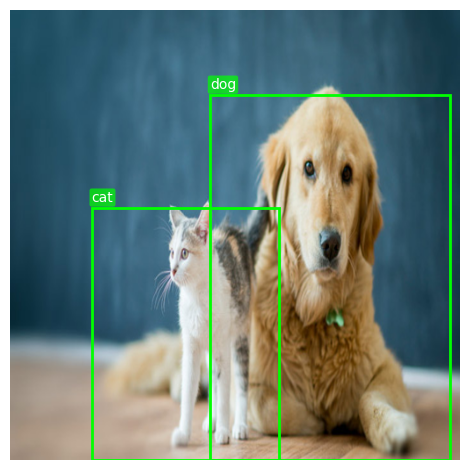

In [9]:
predict('detect dog; cat','examples/pets.jpg')

User:detect car
Assistant: car <loc122><loc074><loc255><loc199>;


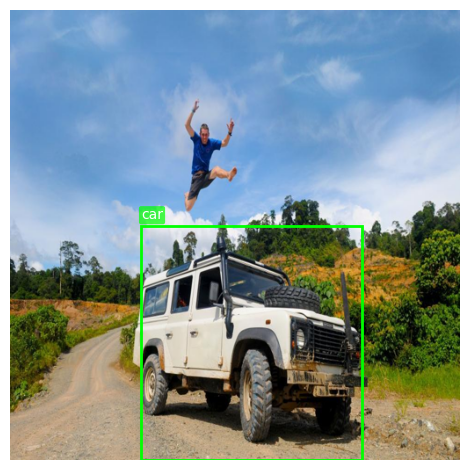

In [10]:
predict('detect car','examples/person_car.jpg')

User:detect car; person
Assistant: car <loc073><loc116><loc196><loc243>;
person <loc000><loc034><loc255><loc144>;


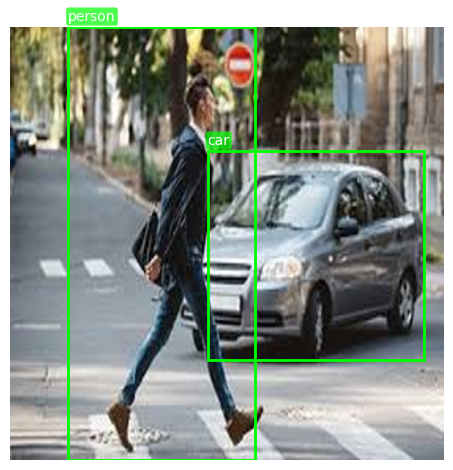

In [11]:
predict('detect car; person','examples/pedestrian.jpg')

User:detect person
Assistant: person <loc043><loc000><loc255><loc083>;
person <loc056><loc166><loc255><loc255>;
person <loc052><loc000><loc255><loc074>;
person <loc055><loc158><loc255><loc255>;


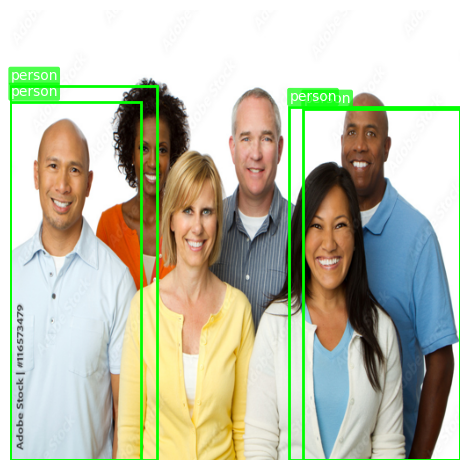

In [12]:
predict('detect person','examples/people.jpg')

User:detect car
Assistant: car <loc066><loc051><loc199><loc173>;


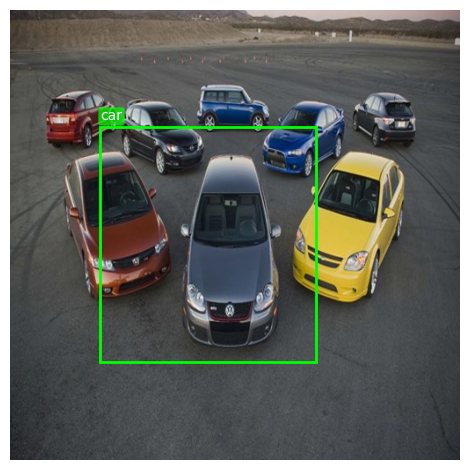

In [13]:
predict('detect car','examples/cars.jpg')

User:detect couch; television
Assistant: couch <loc147><loc088><loc255><loc255>;
television <loc000><loc000><loc144><loc087>;


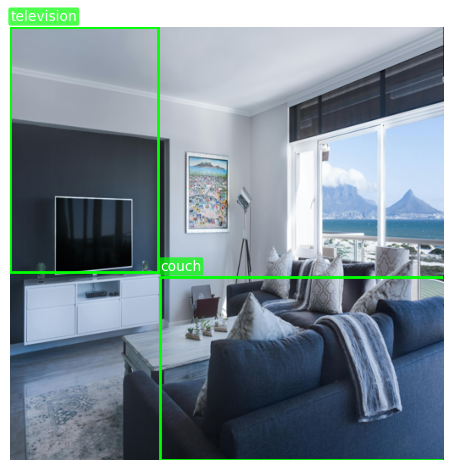

In [17]:
predict('detect couch; television','examples/room.jpg')

User:detect refrigerator; stove
Assistant: refrigerator <loc028><loc132><loc235><loc255>;
stove <loc120><loc000><loc230><loc084>;


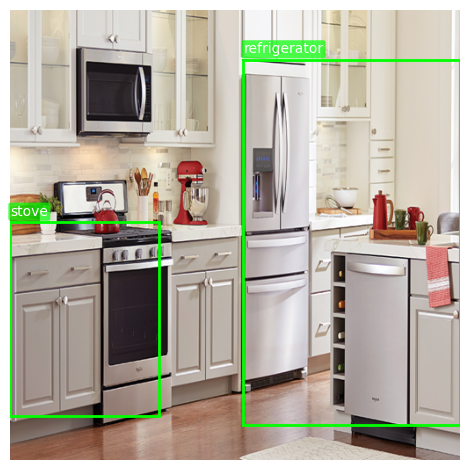

In [16]:
predict('detect refrigerator; stove','examples/kitchen.jpg')